# Visualize Results

In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd
from scipy.stats import median_abs_deviation as mad

In [2]:
mpl.rcParams.update({
    "font.size": 12,            # Base font size
    "axes.titlesize": 12,       # Axes title
    "axes.labelsize": 12,       # Axes labels
    "xtick.labelsize": 10,      # Tick labels
    "ytick.labelsize": 10,
    "legend.fontsize": 12,
    "figure.titlesize": 12
})

- we compare score model with only one condition, and with $k$-conditions
- we show that the scaling in the number of needed sampling steps only depends on the Bayesian Units used
- error reduces when using more conditions, but since network size stays the same, increases at some point again
- we show how mini batching effects the posterior

Metrics:
- KL divergence between true and estimated posterior samples
- RMSE between the medians of true and estimated posterior samples
- Posterior contraction: (1 - var_empirical_posterior / var_prior) / (1 - var_true_posterior / var_prior), and using the mean variances over all parameters

In [9]:
# load results
problem_id = 0  # 0: Gaussian, 1: AR(1), 2: Gaussian with linear schedule, 3: Gaussian with EDM
var_index = 4  # 0: mini_batch, 1: cosine_shift, 2: damping_factor_t, 3: n_conditions,
# 4: damping_factor_t_linear, 5: damping_factor_t_cosine
save_plots = False

if problem_id == 0:
    score_model_names = lambda m_id, n_obs: f'gaussian_flat{m_id}_{n_obs}score_model_v_variance_preserving_cosine_likelihood_weighting'
    score_model_name = 'gaussian_flat_score_model_v_variance_preserving_cosine_likelihood_weighting'
elif problem_id == 1:
    score_model_names = lambda m_id, n_obs: f'ar1_{m_id}_{n_obs}hierarchical_score_model_v_variance_preserving_cosine_likelihood_weighting'
    score_model_name = 'ar1_hierarchical_score_model_v_variance_preserving_cosine_likelihood_weighting'
elif problem_id == 2:
    score_model_names = lambda m_id, n_obs: f'gaussian_flat{m_id}_{n_obs}score_model_v_variance_preserving_linear_likelihood_weighting'
    score_model_name = 'gaussian_flat_score_model_v_variance_preserving_linear_likelihood_weighting'
elif problem_id == 3:
    score_model_names = lambda m_id, n_obs: f'gaussian_flat{m_id}_{n_obs}score_model_F_variance_preserving_edm-sampling_edm'
    score_model_name = 'gaussian_flat_score_model_F_variance_preserving_edm-sampling_edm'
else:
    raise ValueError('Unknown problem_id')

if not os.path.exists('plots/'+score_model_name):
    os.makedirs('plots/'+score_model_name)

variables_of_interest = ['mini_batch', 'cosine_shift', 'damping_factor_t']
variables_of_interest.append('n_conditions')
variables_of_interest += ['damping_factor_t_linear', 'damping_factor_t_cosine']
variable_of_interest = variables_of_interest[var_index]
print(variable_of_interest)

m_ids = np.arange(10)
n_obs = 1 if variable_of_interest != 'n_conditions' else (128 if score_model_name[:2] == 'ar' else 100)

results_list = []
for m_id in m_ids:
    file_name = f'plots/{score_model_names(m_id, n_obs)}/df_results_{variable_of_interest}.csv'
    results_list.append(pd.read_csv(file_name, index_col=0))
df_results = pd.concat(results_list)

# rename column name
df_results['damping_factor_t'] = df_results['damping_factor']

# Ensure we generate enough synthetic data samples.
max_steps = 10000

if variable_of_interest == 'mini_batch':
    show_values = df_results.mini_batch.unique()
    second_variable_of_interest = 'data_size'
elif variable_of_interest == 'n_conditions':
    show_values = df_results.n_conditions.unique()
    second_variable_of_interest = 'data_size'
elif variable_of_interest == 'cosine_shift':
    show_values = df_results.cosine_shift.unique()
    show_values = [0, 5, 10]
    second_variable_of_interest = 'data_size'
elif variable_of_interest == 'damping_factor_t':
    show_values = df_results.damping_factor_t.unique()
    show_values = [1e-5, 0.01, 1.0]  # we used a factor 2 in the damping function
    second_variable_of_interest = 'data_size'
elif variable_of_interest == 'damping_factor_t_linear':
    variable_of_interest = 'damping_factor_t'
    show_values = df_results.damping_factor_t.unique()
    show_values = np.square([1e-5, 0.01, 1.0])  # we used the correct damping factor
    second_variable_of_interest = 'data_size'
elif variable_of_interest == 'damping_factor_t_cosine':
    variable_of_interest = 'damping_factor_t'
    show_values = df_results.damping_factor_t.unique()
    show_values = np.square([1e-5, 0.01, 1.0])  # we used the correct damping factor
    second_variable_of_interest = 'data_size'
else:
    raise ValueError('Unknown variable_of_interest')

# only show parts of the experiments
df_results = df_results[df_results[variable_of_interest].isin(show_values)]

colors = ['#a6cee3', '#1f77b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a']

if score_model_name[:2] != 'ar':
    metrics = {
        'kl': 'KL Divergence',
        'median_rmse': 'RMSE',
        'contractions': 'Posterior\nContraction',
        'c_error': 'Calibration Error'
    }

    # Define the metrics to plot: key is dataframe column, value is label for y-axis.
    y_limits = {
        'median_rmse': (-0.1, 1),
        'contractions': (-0.1, 1.2),
        'c_error': (-0.05, 0.55)
    }
else:
    metrics = {
        'rmse_global': 'RMSE Global',
        'c_error_global': 'Calibration Error\nGlobal',
        'contractions_global': 'Contraction Global',
        'rmse_local': 'RMSE Local',
        'contractions_local': 'Contraction Local'
    }

    # Define the metrics to plot: key is dataframe column, value is label for y-axis.
    y_limits = {
        'rmse_global': (-0.1, 1),
        'rmse_local': (-0.1, 1),
        'contractions_global': (-0.1, 1.2),
        'contractions_local': (-0.1, 1.2),
        'c_error_global': (-0.05, 0.55),
        'c_error_local': (-0.05, 0.55)
    }

experiment_names = {
    'damping_factor_t': 'Damping Factor',
    'damping_factor_t_linear': 'Linear Damping Factor',
    'damping_factor_t_cosine': 'Cosine Damping Factor',
    'n_conditions': 'Number of Conditions',
    'cosine_shift': 'Cosine Shift',
    'data_size': 'Data Size',
    'mini_batch': 'Mini Batch Size'
}

damping_factor_t_linear
plots/gaussian_flat0_1score_model_v_variance_preserving_cosine_likelihood_weighting/df_results_damping_factor_t_linear.csv


EmptyDataError: No columns to parse from file

KeyError: 'damping_factor_t_linear'

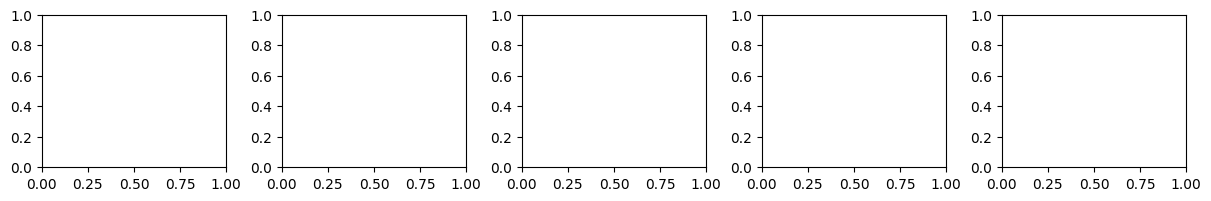

In [5]:
fig, axis = plt.subplots(nrows=1, ncols=len(metrics)+1, sharex=True, figsize=(12, 1.9), constrained_layout=True)
ax = axis[0]

# Group by both second_variable_of_interest and variable_of_interest to compute median and standard deviation of n_steps.
grouped_bar = df_results.groupby([second_variable_of_interest, variable_of_interest])['n_steps'].agg(
    ['median',  mad]
).reset_index()
mad_name = grouped_bar.columns[-1]

# Determine unique second_variable_of_interest and variable_of_interest values.
second_variable_of_interest_values = sorted(grouped_bar[second_variable_of_interest].unique())
variable_batch_values = sorted(grouped_bar[variable_of_interest].unique())

# Set up errorbar plot parameters.
n_groups = len(second_variable_of_interest_values)
n_series = len(variable_batch_values)
x = np.arange(n_groups)  # base x locations for groups

# Plot an errorbar for each variable_of_interest value within each second_variable_of_interest group.
labels = []
handles = []
for i, mb in enumerate(variable_batch_values):
    subset = grouped_bar[grouped_bar[variable_of_interest] == mb]
    medians = []
    mads = []
    for ds in second_variable_of_interest_values:
        row = subset[subset[second_variable_of_interest] == ds]
        if not row.empty:
            medians.append(row['median'].values[0])
            mads.append(row[mad_name].values[0])
        else:
            medians.append(np.nan)
            mads.append(0)

    # Use 'o-' for markers connected by lines.
    h = ax.errorbar(second_variable_of_interest_values, medians, yerr=mads, fmt='o-', capsize=5, label=f'{mb}', alpha=0.75, color=colors[i])
    if variable_of_interest == 'cosine_shift':
        labels.append(f'$s={mb}$')
    elif variable_of_interest == 'damping_factor_t':
        labels.append(f'$d_1={np.round(np.square(mb), 3)}$')  # we used a factor 2 in the damping function
    elif variable_of_interest == 'damping_factor_t_linear':
        labels.append(f'$d_1={np.round(mb, 3)}$')
    elif variable_of_interest == 'damping_factor_t_cosine':
        labels.append(f'$d_1={np.round(mb, 3)}$')
    else:
        labels.append(f'{mb}')
    handles.append(h)

ax.axhline(max_steps, color='k', linestyle='--')
ax.grid(True, which='major', linestyle='--', linewidth=0.5)
ax.text(1, max_steps-5000, "Max Steps", fontsize=10, color='k')

# Center the x-axis ticks and label them.
ax.set_xticks(x)
ax.set_xticklabels(second_variable_of_interest_values)
ax.set_xlabel(experiment_names[second_variable_of_interest])
ax.set_ylabel('Number of Steps')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(10, max_steps*2)

# ------------------------------
# Plot 2: Errorbar plots for MMD, RMSE, and Contraction vs. variable_of_interest.
# ------------------------------
# switch axis
temp = variable_of_interest
variable_of_interest = second_variable_of_interest
second_variable_of_interest = temp

# Filter rows with a variable_of_interest value (skip full-batch rows).
df_mb = df_results[df_results[variable_of_interest].notnull()].copy()
# Convert mini_batch to float (if not already) to allow proper plotting on the x-axis.
df_mb[variable_of_interest] = df_mb[variable_of_interest].astype(float)

# Identify the unique data sizes (to plot different lines per data size).
unique_second_variable_of_interest = sorted(df_mb[second_variable_of_interest].unique())

# Create one figure per metric.
ax = axis[1:]
for j, (metric, metric_label) in enumerate(metrics.items()):
    for i, ds in enumerate(unique_second_variable_of_interest):
        # Select the rows for this particular data size.
        df_sub = df_mb[(df_mb[second_variable_of_interest] == ds) & (df_mb['n_steps'] != max_steps)]
        # Group by variable_of_interest size to get median and mad of the metric.
        grouped = df_sub.groupby(variable_of_interest)[metric].agg(['median', mad]).reset_index()
        if not np.isfinite(grouped['median']).all() or grouped.empty:
            continue
        ax[j].errorbar(grouped[variable_of_interest], grouped['median'], yerr=grouped[mad_name],
                       marker='o', capsize=5, alpha=0.75, color=colors[i])
    ax[j].set_xlabel(experiment_names[variable_of_interest])
    ax[j].set_ylabel(metric_label)
    # Using a logarithmic scale for the x-axis since mini-batch sizes vary widely.
    if metric == 'rel_contraction':
        ax[j].axhline(1, linestyle='--', color='k')
        if variable_of_interest == 'mini_batch':
            ax[j].text(1, 1.05, "Optimal", fontsize=8, color='k')
        elif variable_of_interest == 'n_conditions':
            ax[j].text(1, 1.05, "Optimal", fontsize=8, color='k')
        elif variable_of_interest == 'cosine_shift':
            ax[j].text(1, 1.05, "Optimal", fontsize=8, color='k')
        elif variable_of_interest == 'damping_factor_t':
            ax[j].text(0.1, 1.05, "Optimal", fontsize=8, color='k')
        elif variable_of_interest == 'damping_factor_t_linear':
            ax[j].text(0.1, 1.05, "Optimal", fontsize=8, color='k')
        elif variable_of_interest == 'damping_factor_t_cosine':
            ax[j].text(0.1, 1.05, "Optimal", fontsize=8, color='k')

    if variable_of_interest == 'mini_batch' or variable_of_interest == 'damping_factor_t' or variable_of_interest == 'data_size':
        ax[j].set_xscale('log')
    if metric == 'kl':
        ax[j].set_yscale('log')
        ax[j].grid(True, which='major', linestyle='--', linewidth=0.5)
    else:
        ax[j].set_ylim(y_limits[metric])
        ax[j].grid(True, which='both', linestyle='--', linewidth=0.5)
fig.legend(handles=handles, labels=labels, ncols=len(labels), frameon=False,
           loc='center', bbox_to_anchor=(0.5, -0.05))
if save_plots:
    fig.savefig(f'plots/{score_model_name}/{second_variable_of_interest}.pdf', bbox_inches='tight', transparent=True)
plt.show()

# Compare Number of Step per Information Unit

In [ ]:
variable_of_interest = 'mini_batch'
results_list = []
for m_id in m_ids:
    file_name = f'plots/{score_model_names(m_id, 1)}/df_results_{variable_of_interest}.csv'
    results_list.append(pd.read_csv(file_name, index_col=0))
df_results_mini = pd.concat(results_list)
n_steps_raw = df_results_mini[['n_steps', 'data_size']].groupby('data_size').agg(['median', mad])

variable_of_interest = 'n_conditions'
results_list = []
for m_id in range(10):
    file_name = f'plots/{score_model_names(m_id, 128 if score_model_name[:2] == "ar" else 100)}/df_results_{variable_of_interest}.csv'
    results_list.append(pd.read_csv(file_name, index_col=0))
df_results_cond = pd.concat(results_list)

df_results_cond = df_results_cond[df_results_cond[variable_of_interest].isin([1, 50, 100])]

In [ ]:
fig, axis = plt.subplots(ncols=1, figsize=(4, 3), tight_layout=True)

second_variable_of_interest = 'data_size'
axis = [axis]

for df_results, ax, variable_of_interest in zip([df_results_cond],
                                                [axis[-1]],
                                                ['n_conditions']):

    # Group by both second_variable_of_interest and variable_of_interest to compute median and standard deviation of n_steps.
    grouped_bar = df_results.groupby([second_variable_of_interest, variable_of_interest])['n_steps'].agg(['median', mad]).reset_index()

    # Determine unique second_variable_of_interest and variable_of_interest values.
    second_variable_of_interest_values = sorted(grouped_bar[second_variable_of_interest].unique())
    variable_batch_values = sorted(grouped_bar[variable_of_interest].unique())

    # Set up errorbar plot parameters.
    n_groups = len(second_variable_of_interest_values)
    n_series = len(variable_batch_values)
    x = np.arange(n_groups)  # base x locations for groups

    # Plot an errorbar for each variable_of_interest value within each second_variable_of_interest group.
    for i, mb in enumerate(variable_batch_values):
        subset = grouped_bar[grouped_bar[variable_of_interest] == mb]
        medians = []
        mads = []
        for ds in second_variable_of_interest_values:
            row = subset[subset[second_variable_of_interest] == ds]
            if not row.empty:
                medians.append(row['median'].values[0])
                mads.append(row[mad_name].values[0])
            else:
                medians.append(np.nan)
                mads.append(0)

        medians = np.array(medians)
        medians[medians > max_steps] = max_steps

        # Center the x-axis ticks and label them.
        if variable_of_interest == 'n_conditions':
            ax.errorbar(second_variable_of_interest_values / mb, medians,
                        yerr=mads, fmt='o-', capsize=5, label=f'{mb}', alpha=0.75, color=colors[i])
        else:
            # Use 'o-' for markers connected by lines.
            ax.errorbar(second_variable_of_interest_values, medians, yerr=mads, fmt='o-', capsize=5, label=f'{mb}', alpha=0.75, color=colors[i])

fig.legend(title=r'Number of groups $m$', loc='upper right', ncols=1, frameon=False,
              bbox_to_anchor=(1.44, 0.95))

for ax in axis:
    ax.axhline(max_steps, color='k', linestyle='--')
    ax.text(1, max_steps-3500, "Max Steps", fontsize=8, color='k')
    ax.set_xticks(second_variable_of_interest_values)
    ax.set_xticklabels(second_variable_of_interest_values)
    ax.set_xlabel(r'Number of subsets $k$ of groups')
    ax.set_ylabel('Number of Steps')
    ax.set_yscale('log')
    ax.set_xscale('log')

if save_plots:
    plt.savefig(f'plots/{score_model_name}/{variable_of_interest}_n_steps_conditions.pdf', bbox_inches='tight')
plt.show()